In [1]:
# Dependencies
import json
import hvplot.pandas
import requests
from requests import post
from config import client_secret, client_id
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
import missingno as msno
from fuzzywuzzy import fuzz
import re


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
 #!pip3 install missingno
#it will be useful to install this

In [3]:
 #!pip3 install fuzzywuzzy
#it will be useful to install this

## Bringing in data to join

In [4]:
# Read the csv files from the Resources folder into a Pandas DataFrame
twitch_zaggle_merged_df = pd.read_csv(
    Path("./Resources/TwitchZaggleMerged.csv")
)
additional_genre = pd.read_csv(
    Path("./Resources/Book1.csv")
)
games = pd.read_csv(
    Path("./Resources/games.csv")
)

/var/folders/tf/l4q9ccl500b9zqywywq4xw7h0000gn/T/ipykernel_20038/3893474407.py:2: DtypeWarning: Columns (6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  twitch_zaggle_merged_df = pd.read_csv(


In [5]:
twitch_zaggle_merged_df.head()

,game,year,metacritic_rating,reviewer_rating,positivity_ratio,rating_x,primary_genre,store_genres,publisher,developer,...,hypes,parent_game,rating_y,rating_count,total_rating,total_rating_count,aggregated_rating,aggregated_rating_count,storyline,franchise
0,The Tiny Bang Story,2011.0,63.0,8.0,7.073879,84.85,Adventure,"['Adventure', 'Casual', 'Indie']",Colibri Games,Colibri Games,...,NaN,NaN,72.926984,27.0,71.463492,28.0,70.0,1.0,NaN,NaN
1,World of Guns: Gun Disassembly,2014.0,NaN,8.0,5.208940,82.09,Free,"['Action', 'Casual', 'Free', 'Indie', 'Simulat...",Noble Empire Corp.,Noble Empire Corp.,...,NaN,NaN,66.706351,8.0,66.706351,8.0,NaN,NaN,NaN,NaN
2,Microsoft Flight Simulator 40th Anniversary Ed...,2020.0,91.0,6.0,3.581082,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hacknet,2015.0,82.0,8.0,14.548520,91.41,Simulation,"['Indie', 'Simulation']",Fellow Traveller,Team Fractal Alligator,...,NaN,NaN,77.907238,31.0,82.953619,32.0,88.0,1.0,"Bit, a hacker responsible for creating the mos...",NaN
4,SpaceChem,2011.0,84.0,8.0,11.440415,88.72,Simulation,"['Indie', 'Simulation']",Zachtronics,Zachtronics,...,NaN,NaN,83.151954,25.0,83.151954,25.0,NaN,NaN,NaN,NaN


In [6]:
#length of the merged data
len(twitch_zaggle_merged_df)

289341

In [7]:
additional_genre.head()

,id,game,total_review,review_score,release_date,launch_price,genre
0,730,Counter-Strike: Global Offensive,7382695,88%,8/21/12,$14.99,"FPS, Shooter, Multiplayer, Competitive, Action..."
1,578080,PUBG: BATTLEGROUNDS,2201296,57%,12/21/17,$29.99,"Survival, Shooter, Battle Royale, Multiplayer,..."
2,570,Dota 2,2017009,82%,7/9/13,$29.99,"Free to Play, MOBA, Multiplayer, Strategy, eSp..."
3,271590,Grand Theft Auto V,1322782,89.85%,4/13/15,$29.99,"Open World, Action, Multiplayer, Crime, Automo..."
4,359550,Tom Clancy's Rainbow Six® Siege,978762,86%,12/1/15,$59.99,"FPS, PvP, eSports, Shooter, Multiplayer, Tacti..."


In [8]:
#Split the "list" into lists
additional_genre['genre'] = additional_genre['genre'].str.split(',')
additional_genre['genre'] = additional_genre['genre'].astype('object')  # Update the data type to 'object'

print(additional_genre.dtypes)

id               int64
game            object
total_review     int64
review_score    object
release_date    object
launch_price    object
genre           object
dtype: object


In [9]:
# Keep the last occurrence of each duplicate based on the 'game' column
additional_genre = additional_genre.drop_duplicates(subset=['game'], keep='last')

# Now, 'additional_genre' has unique values in the 'game' column
additional_genre

,id,game,total_review,review_score,release_date,launch_price,genre
0,730,Counter-Strike: Global Offensive,7382695,88%,8/21/12,$14.99,"[FPS, Shooter, Multiplayer, Competitive, A..."
1,578080,PUBG: BATTLEGROUNDS,2201296,57%,12/21/17,$29.99,"[Survival, Shooter, Battle Royale, Multipla..."
2,570,Dota 2,2017009,82%,7/9/13,$29.99,"[Free to Play, MOBA, Multiplayer, Strategy,..."
3,271590,Grand Theft Auto V,1322782,89.85%,4/13/15,$29.99,"[Open World, Action, Multiplayer, Crime, A..."
4,359550,Tom Clancy's Rainbow Six® Siege,978762,86%,12/1/15,$59.99,"[FPS, PvP, eSports, Shooter, Multiplayer, ..."
...,...,...,...,...,...,...,...
65106,1634660,fight,0,0.00%,6/1/21,$199.99,"[Action, Casual, FPS, e sports, Colorful, ..."
65107,1391060,BarbarianAdventure,0,0.00%,9/15/20,$199.99,"[Adventure, Casual, Indie, Strategy]"
65108,1340860,灰烬行星与填鸭少女,0,0.00%,8/8/20,$199.99,"[Casual, Adventure, Visual Novel, Interacti..."
65109,1306150,space shooter,0,50.00%,6/2/20,$199.99,"[Indie, Casual, Action, Space, Minigames]"


In [10]:
# Check for duplicate values in the 'game' column of additional_genre
if additional_genre['game'].duplicated().any():
    print("Warning: Duplicate values found in the 'game' column of additional_genre. Please handle duplicates.")

# Assuming 'game' is a common identifier between twitch_zaggle_merged_df and additional_genre
twitch_zaggle_merged_df['store_genres'] = twitch_zaggle_merged_df['store_genres'].fillna(
    twitch_zaggle_merged_df['game'].map(additional_genre.set_index('game')['genre'])
)

In [11]:
games.head()

,Name,ReleaseDate,ReleaseYear,Developer,Platform,Genres,Publisher,MaxPlayers,ESRB,Overview,Cooperative
0,20th Century Video Almanac,NaN,1993.0,The Software Toolworks,3DO Interactive Multiplayer,Education,The Software Toolworks,1.0,Not Rated,"In The Best of Our Century, we've taken multim...",False
1,3D Atlas,NaN,1994.0,Electronic Arts,3DO Interactive Multiplayer,Education,Electronic Arts,1.0,E - Everyone,3D Atlas for 3DO is an extremely data and art ...,False
2,3DO Action Pak,NaN,1995.0,The 3DO Company,3DO Interactive Multiplayer,Action,The 3DO Company,1.0,Not Rated,This is a four-game compilation pack that cont...,False
3,3DO Demo Disc Program,NaN,NaN,NaN,3DO Interactive Multiplayer,NaN,NaN,NaN,NaN,A white binder with blue silk-screened art. Th...,False
4,3DO Magazine: Interactive Sampler No 02,NaN,NaN,"Crystal Dynamics, Inc.",3DO Interactive Multiplayer,NaN,"Crystal Dynamics, Inc.",1.0,NaN,"Has trailers of Gex, and a game called Cybercl...",False


In [12]:
# Keep the last occurrence of each duplicate based on the 'game' column
games = games.drop_duplicates(subset=['Name'], keep='last')

# Now, 'additional_genre' has unique values in the 'game' column
games.head()

,Name,ReleaseDate,ReleaseYear,Developer,Platform,Genres,Publisher,MaxPlayers,ESRB,Overview,Cooperative
0,20th Century Video Almanac,NaN,1993.0,The Software Toolworks,3DO Interactive Multiplayer,Education,The Software Toolworks,1.0,Not Rated,"In The Best of Our Century, we've taken multim...",False
1,3D Atlas,NaN,1994.0,Electronic Arts,3DO Interactive Multiplayer,Education,Electronic Arts,1.0,E - Everyone,3D Atlas for 3DO is an extremely data and art ...,False
2,3DO Action Pak,NaN,1995.0,The 3DO Company,3DO Interactive Multiplayer,Action,The 3DO Company,1.0,Not Rated,This is a four-game compilation pack that cont...,False
3,3DO Demo Disc Program,NaN,NaN,NaN,3DO Interactive Multiplayer,NaN,NaN,NaN,NaN,A white binder with blue silk-screened art. Th...,False
4,3DO Magazine: Interactive Sampler No 02,NaN,NaN,"Crystal Dynamics, Inc.",3DO Interactive Multiplayer,NaN,"Crystal Dynamics, Inc.",1.0,NaN,"Has trailers of Gex, and a game called Cybercl...",False


In [13]:
# Check for duplicate values in the 'game' column of games
if games['Name'].duplicated().any():
    print("Warning: Duplicate values found in the 'Name' column of games. Please handle duplicates.")

# Assuming 'game' is a common identifier between twitch_zaggle_merged_df and games
twitch_zaggle_merged_df['storyline'] = twitch_zaggle_merged_df['storyline'].fillna(
    twitch_zaggle_merged_df['game'].map(games.set_index('Name')['Overview'])
)

In [14]:
# Assuming 'game' is a common identifier between twitch_zaggle_merged_df and additional_genre
twitch_zaggle_merged_df['store_genres'] = twitch_zaggle_merged_df['store_genres'].fillna(
    twitch_zaggle_merged_df['game'].map(games.set_index('Name')['Genres'])
)

In [15]:
# Assuming 'game' is a common identifier between twitch_zaggle_merged_df and additional_genre
twitch_zaggle_merged_df['year'] = twitch_zaggle_merged_df['year'].fillna(
    twitch_zaggle_merged_df['game'].map(games.set_index('Name')['ReleaseYear'])
)

In [16]:
# Assuming 'game' is a common identifier between twitch_zaggle_merged_df and additional_genre
twitch_zaggle_merged_df['publisher'] = twitch_zaggle_merged_df['publisher'].fillna(
    twitch_zaggle_merged_df['game'].map(games.set_index('Name')['Publisher'])
)

In [17]:
len(twitch_zaggle_merged_df)

289341

In [18]:
twitch_zaggle_merged_df['themes']

0         [17, 35]
1          [1, 34]
2              NaN
3             [43]
4             [18]
            ...   
289336         NaN
289337    [27, 42]
289338     [1, 39]
289339        [18]
289340    [22, 33]
Name: themes, Length: 289341, dtype: object

<Axes: >

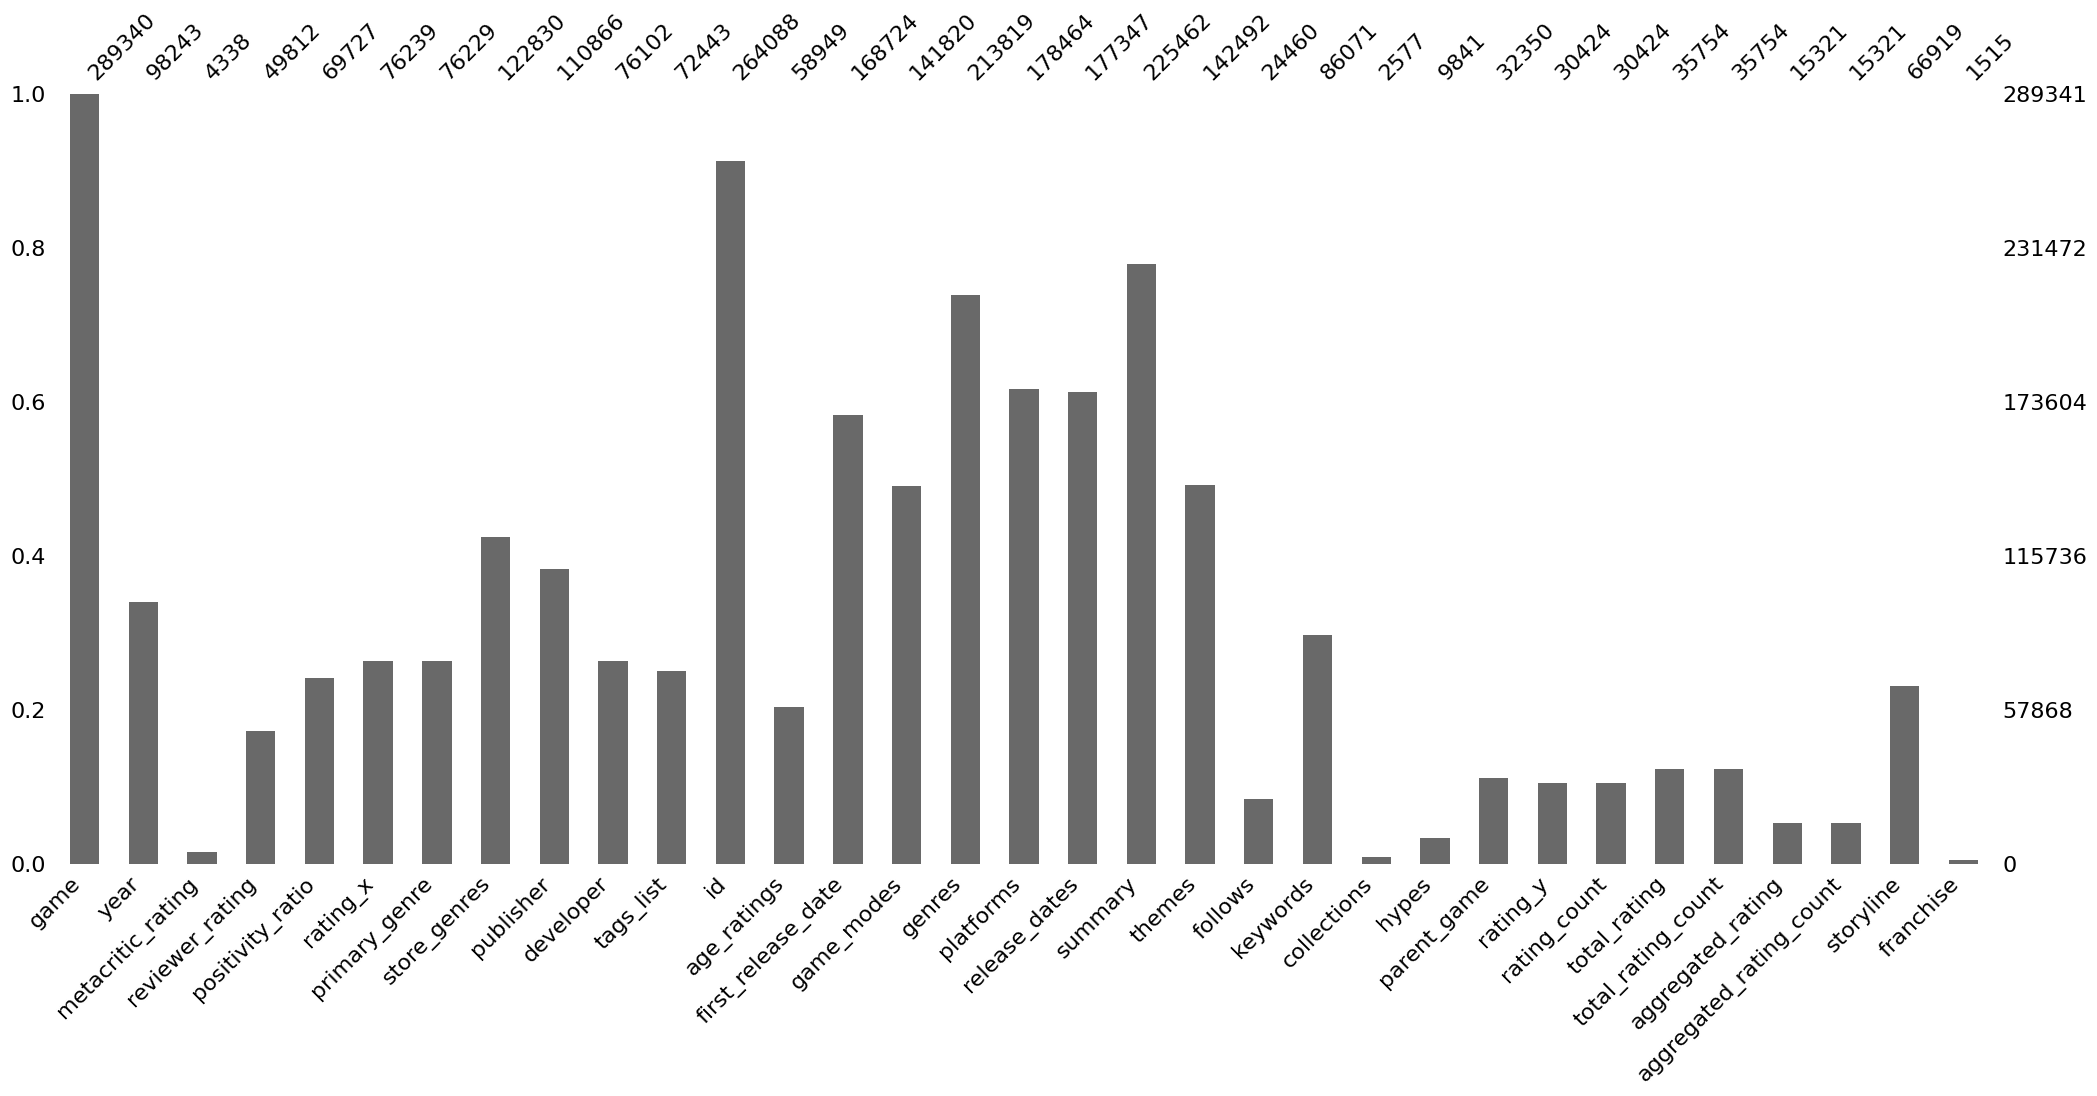

In [19]:
msno.bar(twitch_zaggle_merged_df)

### Dropping NaN Values

In [20]:
# dropping these specific values due to various factors such as number of values, 
# how helpful info is to the machine learning, etc. 
columns_to_drop = ['year', 'age_ratings', 'metacritic_rating', 'rating_x', \
                   'store_genres','publisher','tags_list','primary_genre','release_dates','summary',\
                   'follows','collections','hypes','parent_game','rating_count', 'total_rating', \
                   'total_rating_count','aggregated_rating','platforms', 'aggregated_rating_count', \
                   'storyline','keywords','franchise']

# Drop the specified columns
dropped_df = twitch_zaggle_merged_df.drop(columns=columns_to_drop, axis=1)

In [21]:
#dropping rows that have over 15 columns with NaN values
df_filtered = dropped_df.dropna(thresh=dropped_df.shape[1] - 15)
df_filtered

,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.073879,Colibri Games,15120.0,1.303430e+09,[1],"[2, 7, 9, 31, 32]","[17, 35]",72.926984
1,World of Guns: Gun Disassembly,8.0,5.208940,Noble Empire Corp.,7555.0,1.400630e+09,[1],"[5, 9, 13, 32]","[1, 34]",66.706351
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.581082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.548520,Team Fractal Alligator,11707.0,1.439338e+09,[1],"[9, 13, 32]",[43],77.907238
4,SpaceChem,8.0,11.440415,Zachtronics,8390.0,1.293840e+09,[1],"[9, 13, 15, 32]",[18],83.151954
...,...,...,...,...,...,...,...,...,...,...
289336,Voxel Drivers,NaN,NaN,NaN,114309.0,NaN,[1],"[10, 32]",NaN,40.000000
289337,A Life in Silk: The First Cumming,NaN,NaN,NaN,16309.0,1.467850e+09,[1],"[12, 13, 32]","[27, 42]",77.373272
289338,Black Hornet,NaN,NaN,NaN,14309.0,6.941376e+08,[1],[5],"[1, 39]",NaN
289339,Dig-N-Rig,NaN,NaN,NaN,51309.0,1.264982e+09,NaN,[8],[18],NaN


<Axes: >

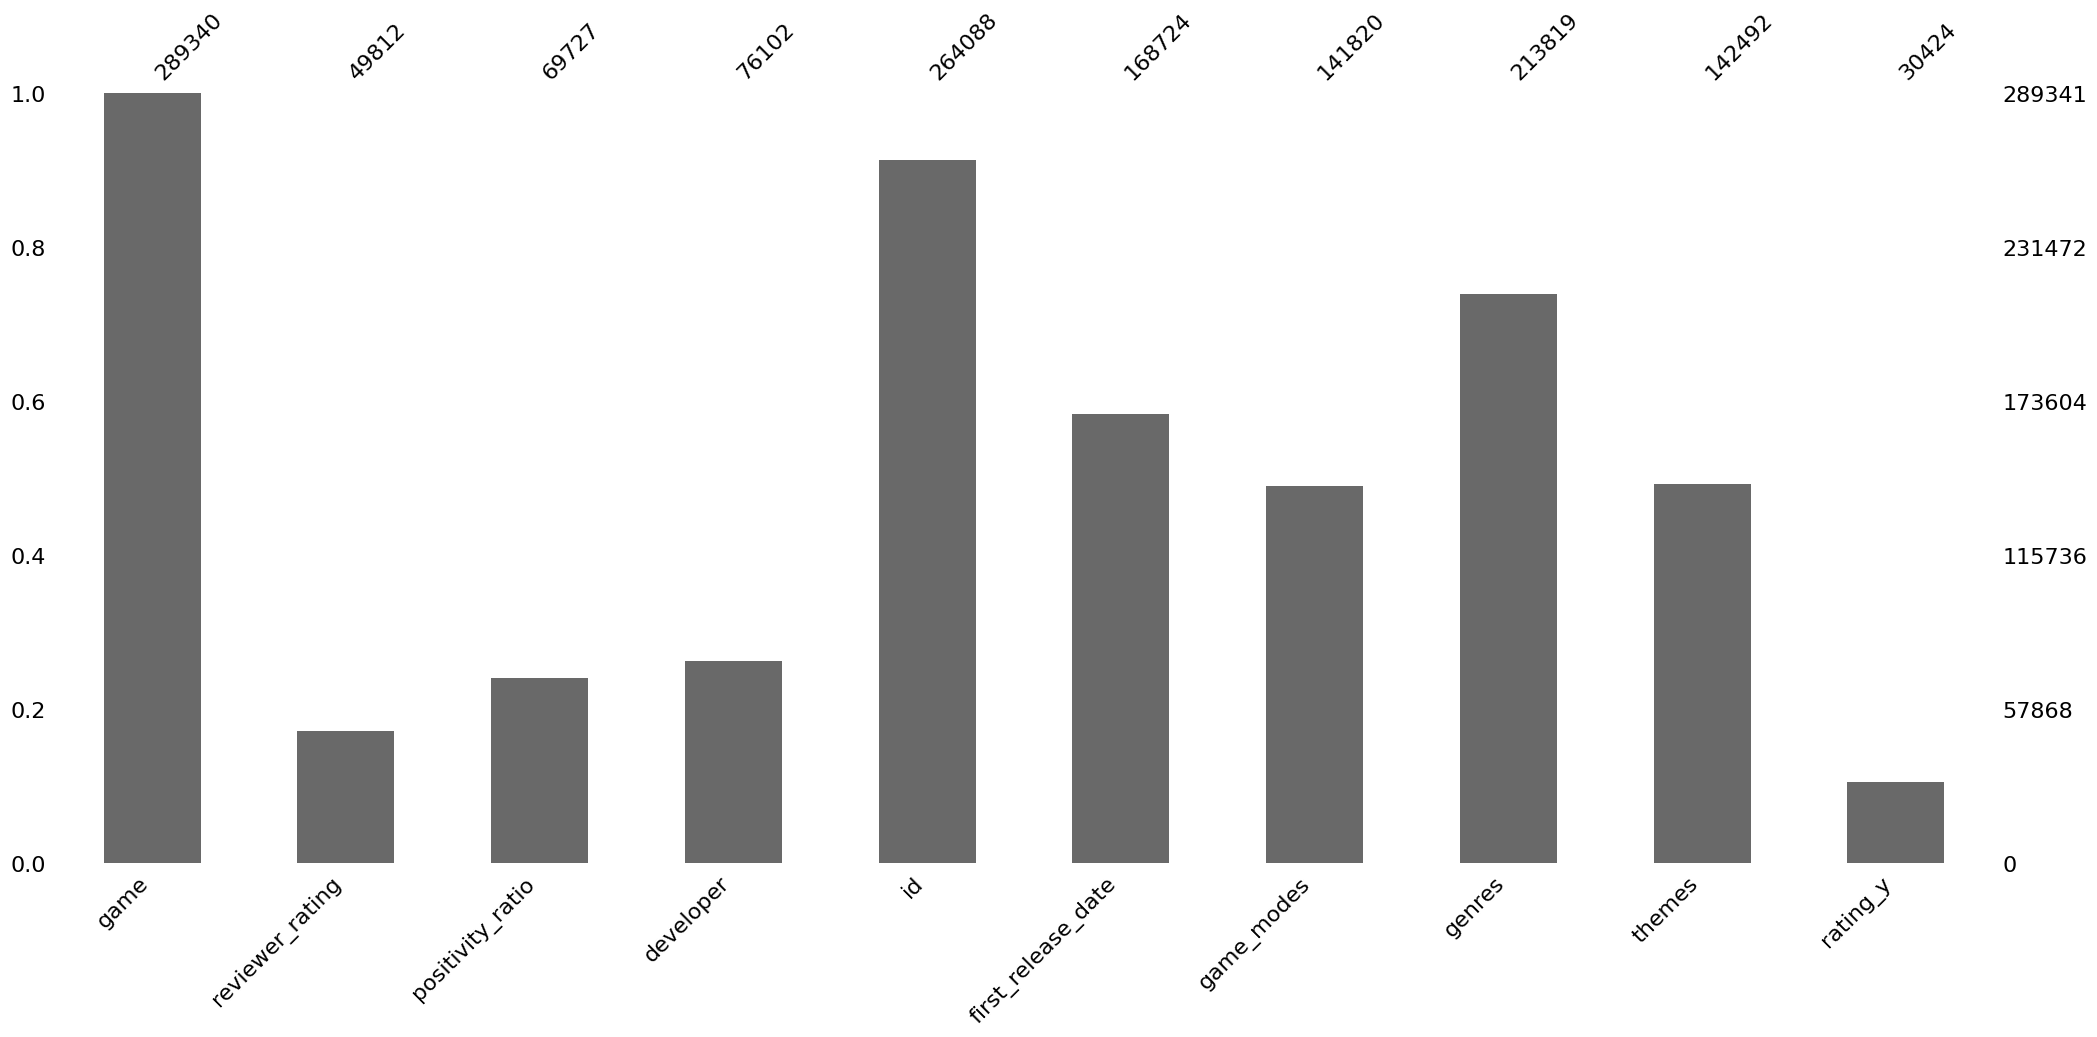

In [22]:
msno.bar(df_filtered)

#### Further cleaning

In [23]:
# Round the 'positivity_ratio' column to two decimal places
df_filtered['positivity_ratio'] = df_filtered['positivity_ratio'].round(2)
# fill.na(0)

# Display the modified DataFrame
df_filtered.head()

,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.07,Colibri Games,15120.0,1.303430e+09,[1],"[2, 7, 9, 31, 32]","[17, 35]",72.926984
1,World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,7555.0,1.400630e+09,[1],"[5, 9, 13, 32]","[1, 34]",66.706351
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.55,Team Fractal Alligator,11707.0,1.439338e+09,[1],"[9, 13, 32]",[43],77.907238
4,SpaceChem,8.0,11.44,Zachtronics,8390.0,1.293840e+09,[1],"[9, 13, 15, 32]",[18],83.151954


In [24]:
# Round the 'rating_y' column to two decimal places
df_filtered['rating_y'] = df_filtered['rating_y'].round(2)

# Display the modified DataFrame
df_filtered.head()

,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.07,Colibri Games,15120.0,1.303430e+09,[1],"[2, 7, 9, 31, 32]","[17, 35]",72.93
1,World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,7555.0,1.400630e+09,[1],"[5, 9, 13, 32]","[1, 34]",66.71
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.55,Team Fractal Alligator,11707.0,1.439338e+09,[1],"[9, 13, 32]",[43],77.91
4,SpaceChem,8.0,11.44,Zachtronics,8390.0,1.293840e+09,[1],"[9, 13, 15, 32]",[18],83.15


In [25]:
# # Extract the first number from each list in the 'genres' column
# df_filtered['genres'] = df_filtered['genres'].str[1]

# # Display the modified DataFrame
# df_filtered.head()

df_filtered['genres'] = df_filtered['genres'].str.extract(r'\[(\d+)')[0]

# Display the modified DataFrame
df_filtered.head()

,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.07,Colibri Games,15120.0,1.303430e+09,[1],2,"[17, 35]",72.93
1,World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,7555.0,1.400630e+09,[1],5,"[1, 34]",66.71
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.55,Team Fractal Alligator,11707.0,1.439338e+09,[1],9,[43],77.91
4,SpaceChem,8.0,11.44,Zachtronics,8390.0,1.293840e+09,[1],9,[18],83.15


In [26]:
# # Convert Unix timestamp to datetime and extract year, month, and day
# df_filtered['release_date'] = pd.to_datetime(df_filtered['first_release_date'], unit='s')
# df_filtered['release_year'] = df_filtered['release_date'].dt.year
# df_filtered['release_month'] = df_filtered['release_date'].dt.month
# df_filtered['release_day'] = df_filtered['release_date'].dt.day

# # Display the modified DataFrame with extracted date components
# df_filtered.head()


#shows the year
df_filtered['first_release_date'] = pd.to_datetime(df_filtered['first_release_date'], unit='s').dt.year
df_filtered['first_release_date'] = df_filtered['first_release_date'].fillna(0).astype(int)
# Display the modified DataFrame with the extracted release year
df_filtered.head()

,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.07,Colibri Games,15120.0,2011,[1],2,"[17, 35]",72.93
1,World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,7555.0,2014,[1],5,"[1, 34]",66.71
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.58,NaN,NaN,0,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.55,Team Fractal Alligator,11707.0,2015,[1],9,[43],77.91
4,SpaceChem,8.0,11.44,Zachtronics,8390.0,2011,[1],9,[18],83.15


In [27]:
### this code takes the first numbers in theme, remove if you want to keep the multiple numbers
df_filtered['themes'] = df_filtered['themes'].str.extract(r'\[(\d+)')[0]

# Display the modified DataFrame
df_filtered.head()

,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.07,Colibri Games,15120.0,2011,[1],2,17,72.93
1,World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,7555.0,2014,[1],5,1,66.71
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.58,NaN,NaN,0,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.55,Team Fractal Alligator,11707.0,2015,[1],9,43,77.91
4,SpaceChem,8.0,11.44,Zachtronics,8390.0,2011,[1],9,18,83.15


In [28]:
### this code takes the first numbers in game_modes, remove if you want to keep the multiple numbers
df_filtered['game_modes'] = df_filtered['game_modes'].str.extract(r'\[(\d+)')[0]

# Display the modified DataFrame
df_filtered.head()

,game,reviewer_rating,positivity_ratio,developer,id,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.07,Colibri Games,15120.0,2011,1,2,17,72.93
1,World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,7555.0,2014,1,5,1,66.71
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.58,NaN,NaN,0,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.55,Team Fractal Alligator,11707.0,2015,1,9,43,77.91
4,SpaceChem,8.0,11.44,Zachtronics,8390.0,2011,1,9,18,83.15


In [29]:
df_filtered.drop(columns = ['id'], inplace = True)

In [30]:
df_filtered.head()

,game,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes,rating_y
0,The Tiny Bang Story,8.0,7.07,Colibri Games,2011,1,2,17,72.93
1,World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,2014,1,5,1,66.71
2,Microsoft Flight Simulator 40th Anniversary Ed...,6.0,3.58,NaN,0,NaN,NaN,NaN,NaN
3,Hacknet,8.0,14.55,Team Fractal Alligator,2015,1,9,43,77.91
4,SpaceChem,8.0,11.44,Zachtronics,2011,1,9,18,83.15


In [31]:
df_filtered.set_index('game', inplace=True)
df_filtered

,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes,rating_y
game,,,,,,,,
The Tiny Bang Story,8.0,7.07,Colibri Games,2011,1,2,17,72.93
World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,2014,1,5,1,66.71
Microsoft Flight Simulator 40th Anniversary Edition,6.0,3.58,NaN,0,NaN,NaN,NaN,NaN
Hacknet,8.0,14.55,Team Fractal Alligator,2015,1,9,43,77.91
SpaceChem,8.0,11.44,Zachtronics,2011,1,9,18,83.15
...,...,...,...,...,...,...,...,...
Voxel Drivers,NaN,NaN,NaN,0,1,10,NaN,40.00
A Life in Silk: The First Cumming,NaN,NaN,NaN,2016,1,12,27,77.37
Black Hornet,NaN,NaN,NaN,1991,1,5,1,NaN


In [32]:
df_filtered.columns

Index(['reviewer_rating', 'positivity_ratio', 'developer',
       'first_release_date', 'game_modes', 'genres', 'themes', 'rating_y'],
      dtype='object')

In [33]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289341 entries, The Tiny Bang Story to Townsmen: A Kingdom Rebuilt
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   reviewer_rating     49812 non-null   float64
 1   positivity_ratio    69727 non-null   float64
 2   developer           76102 non-null   object 
 3   first_release_date  289341 non-null  int64  
 4   game_modes          141820 non-null  object 
 5   genres              213819 non-null  object 
 6   themes              142492 non-null  object 
 7   rating_y            30424 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 19.9+ MB


<Axes: >

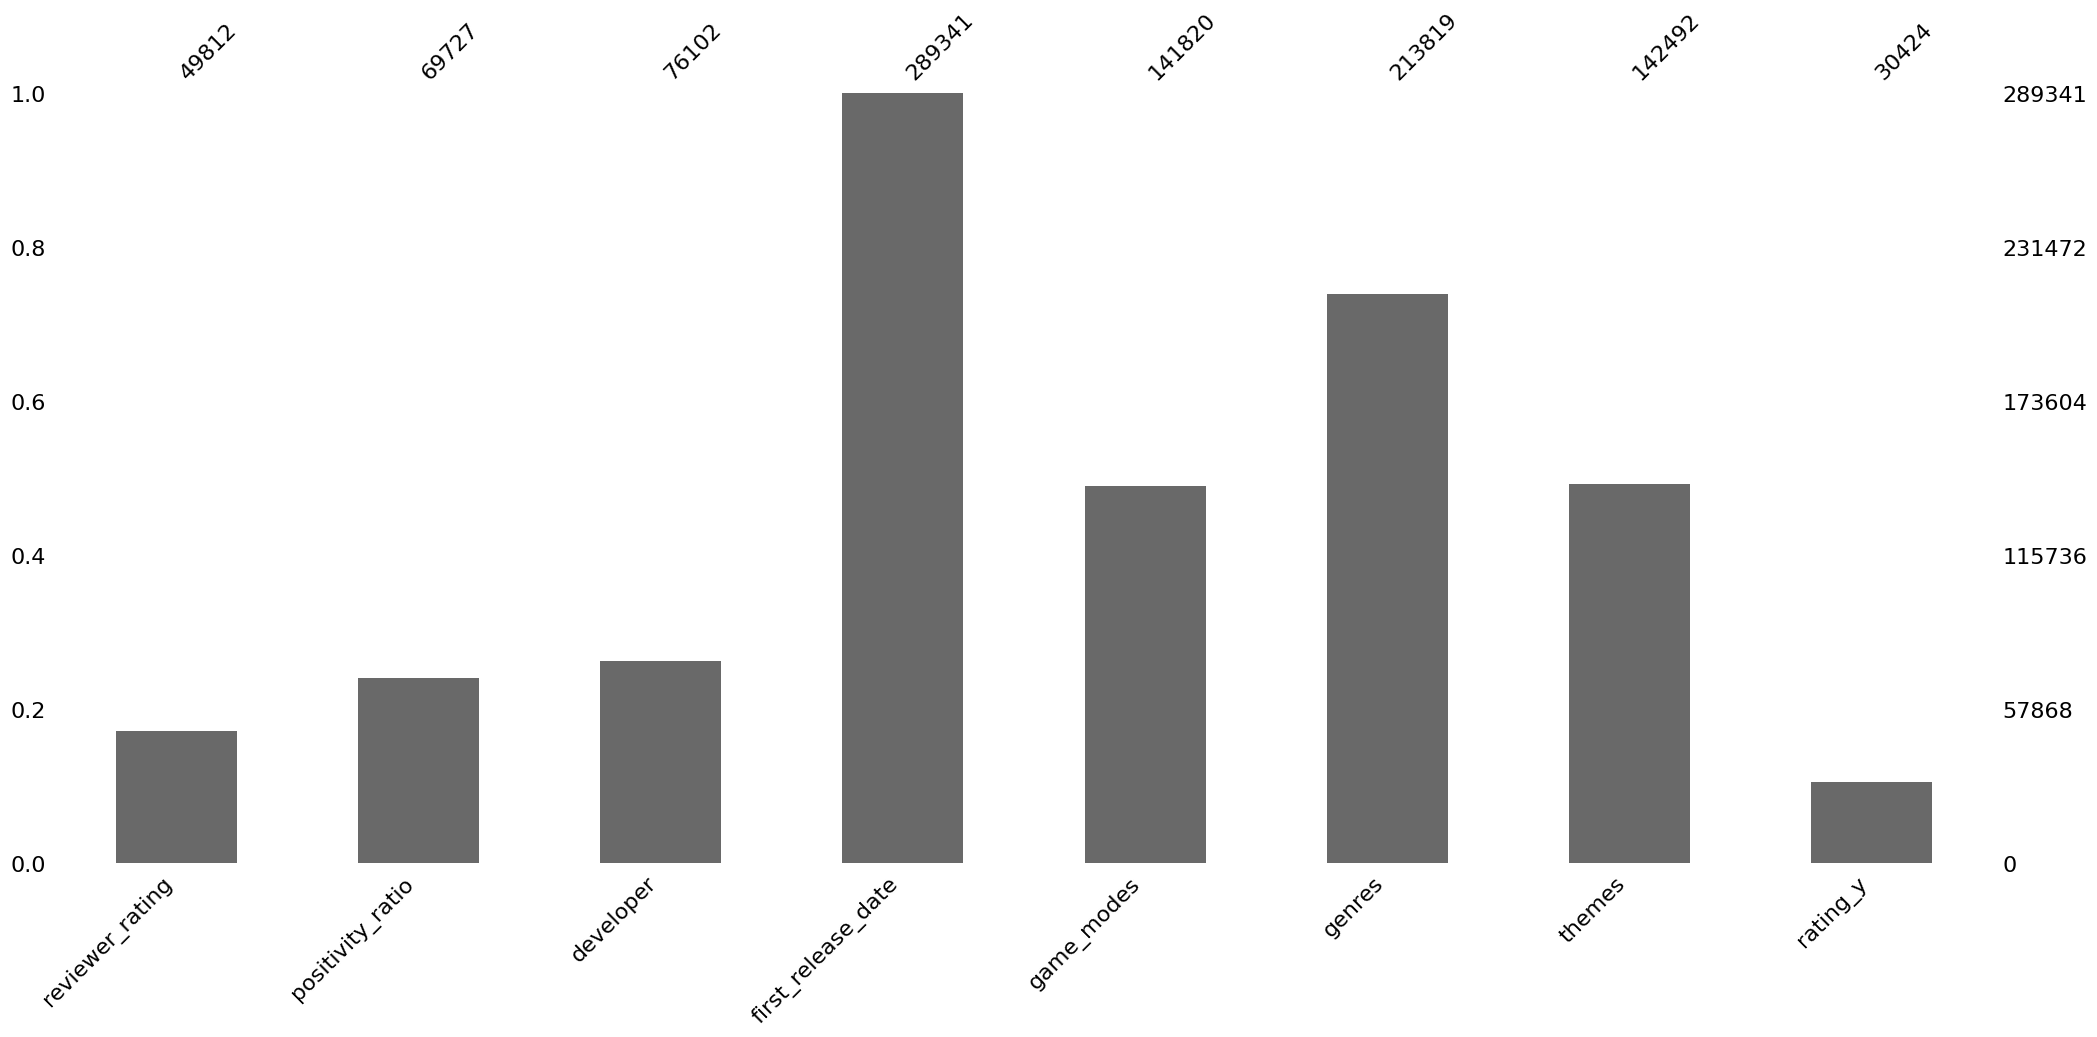

In [34]:
msno.bar(df_filtered)

<Axes: >

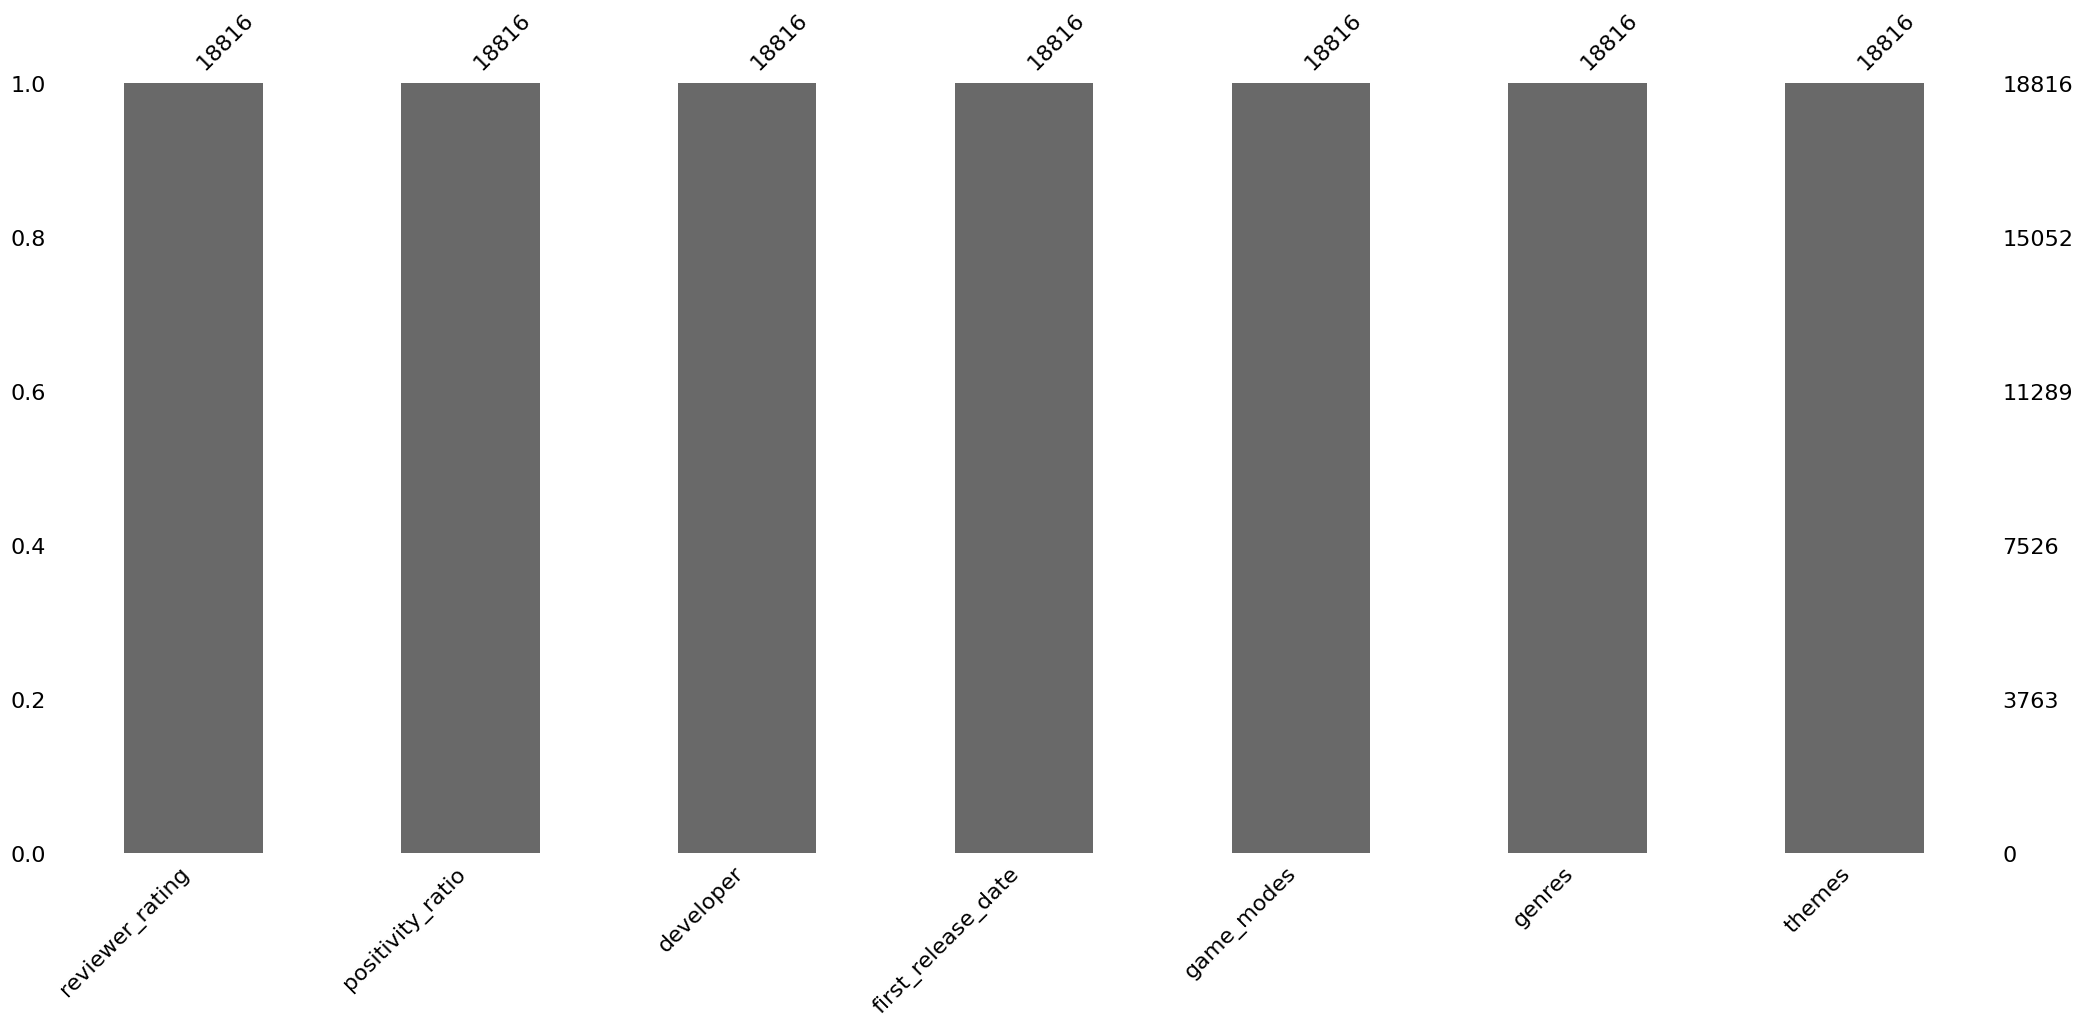

In [35]:
msno.bar(df_filtered.drop(columns = 'rating_y').dropna(how = 'any'))
#cannot imput this because its over 20% of the data missing, so we are going about it this way

In [36]:
df_dropped = df_filtered.drop(columns = 'rating_y').dropna(how = 'any')
df_dropped

,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes
game,,,,,,,
The Tiny Bang Story,8.0,7.07,Colibri Games,2011,1,2,17
World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,2014,1,5,1
Hacknet,8.0,14.55,Team Fractal Alligator,2015,1,9,43
SpaceChem,8.0,11.44,Zachtronics,2011,1,9,18
Learn to Fly 3,8.0,15.57,Light Bringer Games inc.,2017,1,13,1
...,...,...,...,...,...,...,...
Omega Agent,6.0,3.15,Fireproof Games,2016,1,5,1
Time of Shadows,4.0,0.58,SkyFallen Entertainment,2009,1,12,1
Drug Wars,4.0,0.42,Paleo Entertainment,2009,1,5,1


In [37]:
# Identify columns with missing values
# columns_with_missing_values = df_filtered.columns[df_filtered.isnull().any()].tolist()
# columns_with_missing_values
#not dropping these anymore due to the avoidance of imputing

In [38]:
# df_filtered.drop(columns = columns_with_missing_values, inplace = True)
# df_filtered

In [39]:
# for column in columns_with_missing_values:
#     print(f"Processing column: {column}")
    
#     if twitch_zaggle_merged_df[column].dtype == 'float64':
#         imputer = SimpleImputer(strategy='mean')
#     else:
#         imputer = SimpleImputer(strategy='most_frequent')
    
#     # Flatten lists and handle NaN values
#     flattened_values = twitch_zaggle_merged_df[column].apply(lambda x: x if isinstance(x, list) else [x])
#     flattened_values = flattened_values.apply(lambda x: x[0] if len(x) > 0 else np.nan)
    
#     imputed_values = imputer.fit_transform(flattened_values.values.reshape(-1, 1)).ravel()
    
#     print(f"Imputed values: {imputed_values}")
    
#     # Update the DataFrame using loc
#     twitch_zaggle_merged_df.loc[:, column] = imputed_values


# for column in columns_with_missing_values:
#     print(f"Processing column: {column}")
    
#     if df_filtered[column].dtype == 'float64':
#         imputed_values = df_filtered[column].fillna(df_filtered[column].mean())
#     else:
#         # For non-numeric columns, fill missing values with the most frequent value
#         most_frequent_value = df_filtered[column].mode().iloc[0]
#         imputed_values = df_filtered[column].fillna(most_frequent_value)
    
#     print(f"Imputed values: {imputed_values}")
    
#     # Update the DataFrame using loc
#     df_filtered.loc[:, column] = imputed_values

<Axes: ylabel='Frequency'>

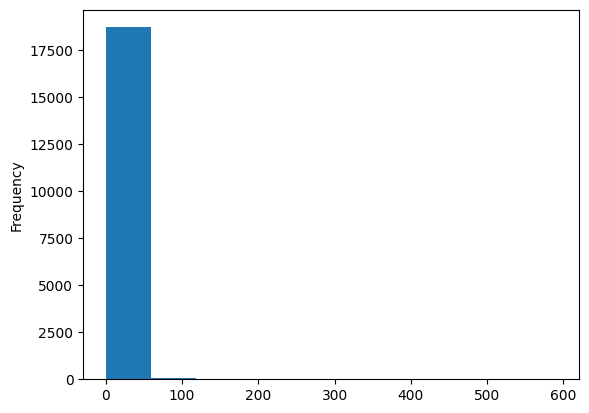

In [40]:
df_dropped.positivity_ratio.plot.hist()

<Axes: >

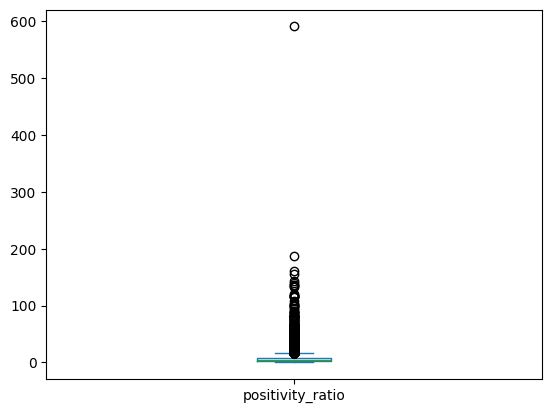

In [41]:
df_dropped.positivity_ratio.plot.box()

In [42]:
# Generate summary statistics
df_dropped.describe(include='all')

,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes
count,18816.000000,18816.000000,18816,18816.000000,18816,18816,18816
unique,NaN,NaN,12219,NaN,6,23,22
top,NaN,NaN,RewindApp,NaN,1,12,1
freq,NaN,NaN,35,NaN,17845,2872,13326
mean,6.489158,6.613834,NaN,1959.705729,NaN,NaN,NaN
std,1.387844,10.248390,NaN,334.021780,NaN,NaN,NaN
min,1.000000,0.040000,NaN,0.000000,NaN,NaN,NaN
25%,5.000000,1.790000,NaN,2015.000000,NaN,NaN,NaN
50%,7.000000,3.640000,NaN,2018.000000,NaN,NaN,NaN
75%,8.000000,7.642500,NaN,2020.000000,NaN,NaN,NaN


In [43]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18816 entries, The Tiny Bang Story to Sangokushi Eiketsuden
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewer_rating     18816 non-null  float64
 1   positivity_ratio    18816 non-null  float64
 2   developer           18816 non-null  object 
 3   first_release_date  18816 non-null  int64  
 4   game_modes          18816 non-null  object 
 5   genres              18816 non-null  object 
 6   themes              18816 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 1.1+ MB


In [44]:
df_dropped[['game_modes','genres','themes']] = df_dropped[['game_modes','genres','themes']].astype('int')
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18816 entries, The Tiny Bang Story to Sangokushi Eiketsuden
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewer_rating     18816 non-null  float64
 1   positivity_ratio    18816 non-null  float64
 2   developer           18816 non-null  object 
 3   first_release_date  18816 non-null  int64  
 4   game_modes          18816 non-null  int64  
 5   genres              18816 non-null  int64  
 6   themes              18816 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 1.1+ MB


In [45]:
df_dropped.describe(include='all')

,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes
count,18816.000000,18816.000000,18816,18816.000000,18816.000000,18816.000000,18816.000000
unique,NaN,NaN,12219,NaN,NaN,NaN,NaN
top,NaN,NaN,RewindApp,NaN,NaN,NaN,NaN
freq,NaN,NaN,35,NaN,NaN,NaN,NaN
mean,6.489158,6.613834,NaN,1959.705729,1.060268,14.701159,7.923257
std,1.387844,10.248390,NaN,334.021780,0.303199,9.936355,11.840972
min,1.000000,0.040000,NaN,0.000000,1.000000,2.000000,1.000000
25%,5.000000,1.790000,NaN,2015.000000,1.000000,8.000000,1.000000
50%,7.000000,3.640000,NaN,2018.000000,1.000000,12.000000,1.000000
75%,8.000000,7.642500,NaN,2020.000000,1.000000,15.000000,17.000000


In [46]:
df_dropped.shape

(18816, 7)

In [47]:
df_dropped.head()

,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes
game,,,,,,,
The Tiny Bang Story,8.0,7.07,Colibri Games,2011,1,2,17
World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,2014,1,5,1
Hacknet,8.0,14.55,Team Fractal Alligator,2015,1,9,43
SpaceChem,8.0,11.44,Zachtronics,2011,1,9,18
Learn to Fly 3,8.0,15.57,Light Bringer Games inc.,2017,1,13,1


In [48]:
# # Find rows with string representations of lists in the 'tags_list' column
# problematic_rows = twitch_zaggle_merged_df[twitch_zaggle_merged_df['tags_list'].apply(lambda x: isinstance(x, str) and '[' in x and ']' in x)]

# # Print the problematic rows
# print(problematic_rows[['tags_list']])

In [49]:
# Extract the second value from the "age_ratings" column and remove square brackets
# df_filtered['age_ratings'] = df_filtered['age_ratings'].str.extract('\[\d+, (\d+)').astype(float)

# # Print unique values in the column after conversion
# print("Unique values after conversion:", df_filtered['age_ratings'].unique())

#ended up removing because the api did not hook up to the other age rating api so it was not able to figure out what the 
#numbers mean

In [50]:
df_dropped.dtypes

reviewer_rating       float64
positivity_ratio      float64
developer              object
first_release_date      int64
game_modes              int64
genres                  int64
themes                  int64
dtype: object

In [51]:
# List of columns to be one-hot encoded
columns_to_encode = ['developer', 'game_modes', 'genres', 'themes']

# Use pd.get_dummies to perform one-hot encoding
df_encoded = pd.get_dummies(df_dropped, columns=columns_to_encode)

# Display the first few rows of the encoded DataFrame
df_encoded

,reviewer_rating,positivity_ratio,first_release_date,developer_#workshop,developer_&quot;Nieko&quot;,developer_&quot;RevDay Studio&quot;,developer_+7 Software,developer_+Mpact Games LLC.,developer_.Cat,developer_.ez Games,...,themes_33,themes_34,themes_35,themes_38,themes_39,themes_40,themes_41,themes_42,themes_43,themes_44
game,,,,,,,,,,,,,,,,,,,,,
The Tiny Bang Story,8.0,7.07,2011,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
World of Guns: Gun Disassembly,8.0,5.21,2014,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Hacknet,8.0,14.55,2015,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
SpaceChem,8.0,11.44,2011,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Learn to Fly 3,8.0,15.57,2017,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Omega Agent,6.0,3.15,2016,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Time of Shadows,4.0,0.58,2009,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Drug Wars,4.0,0.42,2009,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [52]:
df_dropped.developer.value_counts()

developer
RewindApp              35
Ripknot Systems        31
CAPCOM Co. Ltd.        29
Kairosoft Co.Ltd       29
Winged Cloud           28
                       ..
Maximiliano Levi        1
WyvernWare              1
Garden Shed Studios     1
Lead Money Games        1
Paleo Entertainment     1
Name: count, Length: 12219, dtype: int64

In [53]:
#put the ones who show up only once then we want to bin these --in deep learning homework 
#check if there are typos or doubles
#distant base make sure to scale it
#user input through website, then use predict, take in all info to predict

In [54]:
print(df_dropped['developer'].unique())

['Colibri Games' 'Noble Empire Corp.' 'Team Fractal Alligator' ...
 'PyroTechnix' 'SkyFallen Entertainment' 'Paleo Entertainment']


## Cleaning developer column

In [55]:
developer_names = df_dropped['developer'].unique()

for i in range(len(developer_names)):
    for j in range(i + 1, len(developer_names)):
        similarity = fuzz.ratio(developer_names[i], developer_names[j])
        if similarity > 90:  # Adjust the threshold as needed
            print(f'Potential typo or similar name: {developer_names[i]} vs {developer_names[j]}')

Potential typo or similar name: Ripknot Systems vs Ripknot System
Potential typo or similar name: Space Cat Studios vs Space Boat Studios
Potential typo or similar name: Rain Games vs Radin Games
Potential typo or similar name: Wanba Studio vs Wan Studio
Potential typo or similar name: Seen Games vs Sensen Games
Potential typo or similar name: Altar Games vs Altair Game
Potential typo or similar name: Altar Games vs Alter Games
Potential typo or similar name: Rava Games vs Ragiva Games
Potential typo or similar name: EightyEightGames vs EightyEight Games
Potential typo or similar name: Code Force vs CodeForce
Potential typo or similar name: Nifflas' Games vs Nifflas Games
Potential typo or similar name: BambuseaeGames vs Bambuseae Games
Potential typo or similar name: Bonfire Entertainment vs Moonfire Entertainment
Potential typo or similar name: Roost Games vs Robot Games
Potential typo or similar name: Robit Games vs Robot Games
Potential typo or similar name: Aleksandar Kuzmanovic G

In [56]:
# different companies that do not need to be fixed: 
#  Space Cat/Space Boat, Rain Games/Radin Games, Seen Games/Sensen Games, Rava Games/Ragiva Games,
#  Bonfire Entertainment/Moonfire Entertainment, Roost Games/Robot Game,+7 Software/K7 Software,
#  JMJ Interactive/MKJ Interactive, Infinite Studio vs Infinity Studio, Cube Games/Cubyte Games, Basti Games/Beast Games,
#  Onion Games/Orion Games, Galdra Studios/Galdor Studios, Madit Entertainment/Madia Entertainment,
#  Dume Games Studio/Dex Games Studio, CMC Games/MC Games, Mire Studios/Mike Studios,Mobiga Entertainment/Mob Entertainment,
#  Katta Games/Katata Games. Garoa Studios/Guara Studios, Crapcom/Capcom, Blob Games/Bob Games. 
#  Hype ProductionZ/Hyper Productions, Remedy Entertainment/Red Entertainment, Path Games/Pathea Games,
#  Beat Games/Beast Games, Croteam/Creoteam, Grimlore Games/Grimoire Games, Ice Code Games/Ice Cold Games,
#  Red Thread Games/Dead Thread Games, Sigma Games/Xigma Games, Skydome Entertainment,Syndrome Entertainment,
#  Polymorph Games/Polymorphic Games, Kite Games/aitec Games, IOA Games/IO Games, Flying Squirrel/Blind Squirrel,
#  Solid9 Studio/Slid Studio,e-FunSoft Games/unSoft Games, DAX Entertainment/DAB Entertainment,
#  Roach Interactive/Rock Interactive, Go4 Entertainment/G5 Entertainment, Stirling Games/Sirlin Games,
#  TITA Studios/TITI Studios/TT Studios, Madowl Games/Meadow Games, Archage Studios/rchangel Studios,
#  Raba Games/Ratbag Games, Duality Games/Quality Games, Studio4/Studio48, React Games/Redact Games, 
#  Major Games/Majao Games, Flight School Studio/Night School Studio,3D2 Entertainment/T3 Entertainment,
#  IK Interactive/IO Interactive, Likely Games/Lily Games, Reum Entertainment/Red Entertainment,

 
# similarity

In [57]:
misspellings62 = ['CAPCOM CO. LTD', 'CAPCOM CO. LTD.']
correct_spelling62 = "Capcom Co"

for misspelling62 in misspellings62:
    corrected_string62 = re.sub(r"^(CAPCOM CO. LTD|CAPCOM CO. LTD.)$", correct_spelling62, misspelling62)
    print(corrected_string62)

Capcom Co
Capcom Co


In [58]:
misspellings61 = ['Fullmetal Developer', 'FullmetalDeveloper']
correct_spelling61 = "Fullmetal Developer"

for misspelling61 in misspellings61:
    corrected_string61 = re.sub(r"^(Fullmetal Developer|FullmetalDeveloper)$", correct_spelling61, misspelling61)
    print(corrected_string61)

Fullmetal Developer
Fullmetal Developer


In [59]:
misspellings60 = ['Machine Games', 'MachineGames']
correct_spelling60 = "MachineGames"

for misspelling60 in misspellings60:
    corrected_string60 = re.sub(r"^(Machine Games|MachineGames)$", correct_spelling60, misspelling60)
    print(corrected_string60)

MachineGames
MachineGames


In [60]:
misspellings59 = ['Phantom8 Studio', 'Phantom 8 Studio']
correct_spelling59 = "Phantom 8 Studio"

for misspelling59 in misspellings59:
    corrected_string59 = re.sub(r"^(Phantom8 Studio|Phantom 8 Studio)$", correct_spelling59, misspelling59)
    print(corrected_string59)

Phantom 8 Studio
Phantom 8 Studio


In [61]:
misspellings58 = ['Accolade Inc.', 'Accolade Inc']
correct_spelling58 = "Accolade Inc"

for misspelling58 in misspellings58:
    corrected_string58 = re.sub(r"^(Accolade Inc.|Accolade Inc)$", correct_spelling58, misspelling58)
    print(corrected_string58)

Accolade Inc
Accolade Inc


In [62]:
misspellings57 = ['DuplicatorStudio', 'Duplicator Studio']
correct_spelling57 = "Duplicator Studio"

for misspelling57 in misspellings57:
    corrected_string57 = re.sub(r"^(DuplicatorStudio|Duplicator Studio)$", correct_spelling57, misspelling57)
    print(corrected_string57)

Duplicator Studio
Duplicator Studio


In [63]:
misspellings56 = ['Ubisoft Montreal', 'Ubisoft Montréal']
correct_spelling56 = "Ubisoft Montreal"

for misspelling56 in misspellings56:
    corrected_string56 = re.sub(r"^(Ubisoft Montreal|Ubisoft Montréal)$", correct_spelling56, misspelling56)
    print(corrected_string56)

Ubisoft Montreal
Ubisoft Montreal


In [64]:
misspellings55 = ['BBC Media Applications Technologies Limited', 'BBC Media Applications Technologies Ltd']
correct_spelling55 = "BBC Media Applications Technologies"

for misspelling55 in misspellings55:
    corrected_string55 = re.sub(r"^(BBC Media Applications Technologies Limited|BBC Media Applications Technologies Ltd)$", correct_spelling55, misspelling55)
    print(corrected_string55)

BBC Media Applications Technologies
BBC Media Applications Technologies


In [65]:
misspellings54 = ['Free Reign Entertainment LLC', 'Free Reign Entertainment']
correct_spelling54 = "Free Reign Entertainment"

for misspelling54 in misspellings54:
    corrected_string54 = re.sub(r"^(Free Reign Entertainment LLC|Free Reign Entertainment)$", correct_spelling54, misspelling54)
    print(corrected_string54)

Free Reign Entertainment
Free Reign Entertainment


In [66]:
misspellings53 = ['Spicyhorse Games', 'Spicy Horse Games']
correct_spelling53 = "Spicy Horse Games"

for misspelling53 in misspellings53:
    corrected_string53 = re.sub(r"^(Spicyhorse Games|Spicy Horse Games)$", correct_spelling53, misspelling53)
    print(corrected_string53)

Spicy Horse Games
Spicy Horse Games


In [67]:
misspellings52 = ['LillyWelland inc.', 'LillyWelland Inc.']
correct_spelling52 = "LillyWelland Inc"

for misspelling52 in misspellings52:
    corrected_string52 = re.sub(r"^(LillyWelland inc.|LillyWelland Inc.)$", correct_spelling52, misspelling52)
    print(corrected_string52)

LillyWelland Inc
LillyWelland Inc


In [68]:
misspellings51 = ['Black Banshee Studios', 'BlackBanshee Studios']
correct_spelling51 = "Black Banshee Studios"

for misspelling51 in misspellings51:
    corrected_string51 = re.sub(r"^(Black Banshee Studios|BlackBanshee Studios)$", correct_spelling51, misspelling51)
    print(corrected_string51)

Black Banshee Studios
Black Banshee Studios


In [69]:
misspellings50 = ['Horizon Studios', 'Horizon Studio']
correct_spelling50 = "Horizon Studios"

for misspelling50 in misspellings50:
    corrected_string50 = re.sub(r"^(Horizon Studios|Horizon Studio)$", correct_spelling50, misspelling50)
    print(corrected_string50)

Horizon Studios
Horizon Studios


In [70]:
misspellings49 = ['Immersive VR Education Ltd', 'Immersive VR Education']
correct_spelling49 = "Immersive VR Education"

for misspelling49 in misspellings49:
    corrected_string49 = re.sub(r"^(Immersive VR Education Ltd|Immersive VR Education)$", correct_spelling49, misspelling49)
    print(corrected_string49)

Immersive VR Education
Immersive VR Education


In [71]:
misspellings48 = ['Perfect Games', 'Perfect games']
correct_spelling48 = "Perfect Games"

for misspelling48 in misspellings48:
    corrected_string48 = re.sub(r"^(Perfect Games|Perfect games)$", correct_spelling48, misspelling48)
    print(corrected_string48)

Perfect Games
Perfect Games


In [72]:
misspellings47 = ['BisquitGames', 'BiscuitGames']
correct_spelling47 = "BiscuitGames"

for misspelling47 in misspellings47:
    corrected_string47 = re.sub(r"^(BisquitGames|BiscuitGames)$", correct_spelling47, misspelling47)
    print(corrected_string47)

BiscuitGames
BiscuitGames


In [73]:
misspellings46 = ['Digital Dreams Entertainment', 'Digital Dreams Entertainment LLC']
correct_spelling46 = "Digital Dreams Entertainment"

for misspelling46 in misspellings46:
    corrected_string46 = re.sub(r"^(Digital Dreams Entertainment|Digital Dreams Entertainment LLC)$", correct_spelling46, misspelling46)
    print(corrected_string46)

Digital Dreams Entertainment
Digital Dreams Entertainment


In [74]:
misspellings45 = ['Independent Arts Software GmbH', 'Independent Arts Software']
correct_spelling45 = "Independent Arts Software"

for misspelling45 in misspellings45:
    corrected_string45 = re.sub(r"^(Independent Arts Software GmbH|Independent Arts Software)$", correct_spelling45, misspelling45)
    print(corrected_string45)

Independent Arts Software
Independent Arts Software


In [75]:
misspellings44 = ['RC Knight', 'R C Knight']
correct_spelling44 = "RC Knight"

for misspelling44 in misspellings44:
    corrected_string44 = re.sub(r"^(RC Knight|R C Knight)$", correct_spelling44, misspelling44)
    print(corrected_string44)

RC Knight
RC Knight


In [76]:
misspellings43 = ['GameOn Production', 'Game On Production']
correct_spelling43 = "GameOn Production"

for misspelling43 in misspellings43:
    corrected_string43 = re.sub(r"^(GameOn Production|Game On Production)$", correct_spelling43, misspelling43)
    print(corrected_string43)

GameOn Production
GameOn Production


In [77]:
misspellings42 = ['Labrodex Inc', 'Labrodex Inc.']
correct_spelling42 = "Labrodex Inc"

for misspelling42 in misspellings42:
    corrected_string42 = re.sub(r"^(Labrodex Inc|Labrodex Inc.)$", correct_spelling42, misspelling42)
    print(corrected_string42)

Labrodex Inc
Labrodex Inc


In [78]:
misspellings41 = ['Platinum Games', 'PlatinumGames']
correct_spelling41 = "PlatinumGames"

for misspelling41 in misspellings41:
    corrected_string41 = re.sub(r"^(Platinum Games|TPlatinumGames)$", correct_spelling41, misspelling41)
    print(corrected_string41)

PlatinumGames
PlatinumGames


In [79]:
misspellings40 = ['T3Entertainment', 'T3 Entertainment']
correct_spelling40 = "T3 Entertainment"

for misspelling40 in misspellings40:
    corrected_string40 = re.sub(r"^(T3Entertainment|T3 Entertainment)$", correct_spelling40, misspelling40)
    print(corrected_string40)

T3 Entertainment
T3 Entertainment


In [80]:
misspellings39 = ['Chris Antoni', 'Chris_Antoni']
correct_spelling39 = "Chris Antoni"

for misspelling39 in misspellings39:
    corrected_string39 = re.sub(r"^(Chris Antoni|Chris_Antoni)$", correct_spelling39, misspelling39)
    print(corrected_string39)

Chris Antoni
Chris Antoni


In [81]:
misspellings38 = ['Praxia Entertainment Inc', 'Praxia Entertainment']
correct_spelling38 = "Praxia Entertainment"

for misspelling38 in misspellings38:
    corrected_string38 = re.sub(r"^(Praxia Entertainment Inc|Praxia Entertainment)$", correct_spelling38, misspelling38)
    print(corrected_string38)

Praxia Entertainment
Praxia Entertainment


In [82]:
misspellings37 = ['Exato Game Studios', 'Exato Games Studio']
correct_spelling37 = "Exato Game Studios"

for misspelling37 in misspellings37:
    corrected_string37 = re.sub(r"^(Exato Game Studios|Exato Games Studio)$", correct_spelling37, misspelling37)
    print(corrected_string37)

Exato Game Studios
Exato Game Studios


In [83]:
misspellings36 = ['Web Interactive Solutions.', 'Web Interactive Solutions']
correct_spelling36 = "Web Interactive Solutions"

for misspelling36 in misspellings36:
    corrected_string36 = re.sub(r"^(Web Interactive Solutions.|Web Interactive Solutions)$", correct_spelling36, misspelling36)
    print(corrected_string36)

Web Interactive Solutions
Web Interactive Solutions


In [84]:
misspellings35 = ['ZGame Studio', 'Zgame Studio']
correct_spelling35 = "ZGame Studio"

for misspelling35 in misspellings35:
    corrected_string35 = re.sub(r"^(ZGame Studio|Zgame Studio)$", correct_spelling35, misspelling35)
    print(corrected_string35)

ZGame Studio
ZGame Studio


In [85]:
misspellings34 = ['Totem Games', 'Totem games']
correct_spelling34 = "Totem Games"

for misspelling34 in misspellings34:
    corrected_string34 = re.sub(r"^(Totem Games|Totem games)$", correct_spelling34, misspelling34)
    print(corrected_string34)

Totem Games
Totem Games


In [86]:
misspellings33 = ['Random Thoughts Entertainment', 'Random Thoughts Enterainment']
correct_spelling33 = "Random Thoughts Entertainment"

for misspelling33 in misspellings33:
    corrected_string33 = re.sub(r"^(Random Thoughts Entertainment|Random Thoughts Enterainment)$", correct_spelling33, misspelling33)
    print(corrected_string33)

Random Thoughts Entertainment
Random Thoughts Entertainment


In [87]:
misspellings32 = ['Zero Sum Games', 'Zero Sun Games']
correct_spelling32 = "Zero Sum Games"

for misspelling32 in misspellings32:
    corrected_string32 = re.sub(r"^(Zero Sum Games|Zero Sun Games)$", correct_spelling32, misspelling32)
    print(corrected_string32)

Zero Sum Games
Zero Sum Games


In [88]:
misspellings31 = ['Games Distillery s.r.o.', 'Game Distillery s.r.o.']
correct_spelling31 = "Games Distillery"

for misspelling31 in misspellings31:
    corrected_string31 = re.sub(r"^(Games Distillery s.r.o.|Game Distillery s.r.o.)$", correct_spelling31, misspelling31)
    print(corrected_string31)

Games Distillery
Games Distillery


In [89]:
misspellings30 = ['Joy Impact', 'JoyImpact']
correct_spelling30 = "JoyImpact"

for misspelling30 in misspellings30:
    corrected_string30 = re.sub(r"^(Joy Impact|JoyImpact)$", correct_spelling30, misspelling30)
    print(corrected_string30)

JoyImpact
JoyImpact


In [90]:
misspellings29 = ['United Independent Entertainment.', 'United Independent Entertainment GmbH']
correct_spelling29 = "United Independent Entertainment"

for misspelling29 in misspellings29:
    corrected_string29 = re.sub(r"^(United Independent Entertainment|United Independent Entertainment GmbH)$", correct_spelling29, misspelling29)
    print(corrected_string29)

United Independent Entertainment.
United Independent Entertainment


In [91]:
misspellings28 = ['historia Inc.', 'historia Inc']
correct_spelling28 = "Historia Inc"

for misspelling28 in misspellings28:
    corrected_string28 = re.sub(r"^(historia Inc.|historia Inc)$", correct_spelling28, misspelling28)
    print(corrected_string28)

Historia Inc
Historia Inc


In [92]:
misspellings27 = ['Red Dot Games', 'RedDot Games']
correct_spelling27 = "Red Dot Games"

for misspelling27 in misspellings27:
    corrected_string27 = re.sub(r"^(Red Dot Games|RedDot Games)$", correct_spelling27, misspelling27)
    print(corrected_string27)

Red Dot Games
Red Dot Games


In [93]:
misspellings26 = ['Stainless Games Ltd', 'Stainless Games Ltd.']
correct_spelling26 = "Stainless Games"

for misspelling26 in misspellings26:
    corrected_string26 = re.sub(r"^(Stainless Games Ltd|Stainless Games Ltd.)$", correct_spelling26, misspelling26)
    print(corrected_string26)

Stainless Games
Stainless Games


In [94]:
misspellings25 = ['Appeal Studio', 'Appeal Studios']
correct_spelling25 = "Appeal Studios"

for misspelling25 in misspellings25:
    corrected_string25 = re.sub(r"^(Appeal Studio|Appeal Studios)$", correct_spelling25, misspelling25)
    print(corrected_string25)

Appeal Studios
Appeal Studios


In [95]:
misspellings24 = ['MicroProse Software Inc', 'MicroProse Software Inc.']
correct_spelling24 = "MicroProse Software"

for misspelling24 in misspellings24:
    corrected_string24 = re.sub(r"^(MicroProse Software Inc|MicroProse Software Inc.)$", correct_spelling24, misspelling24)
    print(corrected_string24)

MicroProse Software
MicroProse Software


In [96]:
misspellings23 = ['Cyanide Studio', 'Cyanide Studios']
correct_spelling23 = "Cyanide Studio"

for misspelling23 in misspellings23:
    corrected_string23 = re.sub(r"^(Cyanide Studio|Cyanide Studios)$", correct_spelling23, misspelling23)
    print(corrected_string23)

Cyanide Studio
Cyanide Studio


In [97]:
misspellings22 = ['Deck 13', 'Deck13']
correct_spelling22 = "Deck13"

for misspelling22 in misspellings22:
    corrected_string22 = re.sub(r"^(Deck 13|Deck13)$", correct_spelling22, misspelling22)
    print(corrected_string22)

Deck13
Deck13


In [98]:
misspellings21 = ['Dynamic Zero', 'Dynamic zero']
correct_spelling21 = "Dynamic Zero"

for misspelling21 in misspellings21:
    corrected_string21 = re.sub(r"^(Dynamic Zero|Dynamic zero)$", correct_spelling21, misspelling21)
    print(corrected_string21)

Dynamic Zero
Dynamic Zero


In [99]:
misspellings20 = ['DDreams Games', 'Dream Games']
correct_spelling20 = "Dream Games"

for misspelling20 in misspellings20:
    corrected_string20 = re.sub(r"^(DDreams Games|Dream Games)$", correct_spelling20, misspelling20)
    print(corrected_string20)

Dream Games
Dream Games


In [100]:
misspellings19 = ['AKGames', 'AK Games']
correct_spelling19 = "AKGames"

for misspelling19 in misspellings19:
    corrected_string19 = re.sub(r"^(AKGames|AK Games)$", correct_spelling19, misspelling19)
    print(corrected_string19)

AKGames
AKGames


In [101]:
misspellings18 = ['Yustas Games Studio', 'Yustas Game Studio']
correct_spelling18 = "Yustas Games Studio"

for misspelling18 in misspellings18:
    corrected_string18 = re.sub(r"^(Yustas Games Studio|Yustas Game Studio)$", correct_spelling18, misspelling18)
    print(corrected_string18)

Yustas Games Studio
Yustas Games Studio


In [102]:
misspellings17 = ['WildSphere', 'Wild Sphere']
correct_spelling17 = "WildSphere"

for misspelling17 in misspellings17:
    corrected_string17 = re.sub(r"^(WildSphere|Wild Sphere)$", correct_spelling17, misspelling17)
    print(corrected_string17)

WildSphere
WildSphere


In [103]:
misspellings16 = ['RainbowStudio', 'Rainbow Studios']
correct_spelling16 = "Rainbow Studios"

for misspelling16 in misspellings16:
    corrected_string16 = re.sub(r"^(RainbowStudio|Rainbow Studios)$", correct_spelling16, misspelling16)
    print(corrected_string16)

Rainbow Studios
Rainbow Studios


In [104]:
misspellings15 = ['BTrain Studio']
correct_spelling15 = "Brain Games Studio"

for misspelling15 in misspellings15:
    corrected_string15 = re.sub(r"^(BTrain Studio)$", correct_spelling15, misspelling15)
    print(corrected_string15)

Brain Games Studio


In [105]:
misspellings14 = ['Brutal muse', 'Brutal Muse']
correct_spelling14 = "Brutal Muse"

for misspelling14 in misspellings14:
    corrected_string14 = re.sub(r"^(Brutal muse|Brutal Muse)$", correct_spelling14, misspelling14)
    print(corrected_string14)

Brutal Muse
Brutal Muse


In [106]:
misspellings13 = ['nFusion Interactive', 'N-Fusion Interactive']
correct_spelling13 = "N-Fusion Interactive"

for misspelling13 in misspellings13:
    corrected_string13 = re.sub(r"^(nFusion Interactive|N-Fusion Interactive)$", correct_spelling13, misspelling13)
    print(corrected_string13)

N-Fusion Interactive
N-Fusion Interactive


In [107]:
misspellings12 = ['Skeleton Crew Studio', 'Skeleton Crew Studios']
correct_spelling12 = "Skeleton Crew Studios"

for misspelling12 in misspellings12:
    corrected_string12 = re.sub(r"^(Skeleton Crew Studio|Skeleton Crew Studios)$", correct_spelling12, misspelling12)
    print(corrected_string12)

Skeleton Crew Studios
Skeleton Crew Studios


In [108]:
misspellings11 = ['VDO Games', 'VD Games']
correct_spelling11 = "VD Games"

for misspelling11 in misspellings11:
    corrected_string11 = re.sub(r"^(VDO Games|VD Games)$", correct_spelling11, misspelling11)
    print(corrected_string11)

VD Games
VD Games


In [109]:
misspellings10 = ['Dharker Studio', 'Dharker Studios']
correct_spelling10 = "Dharker Studios"

for misspelling10 in misspellings10:
    corrected_string10 = re.sub(r"^(Dharker Studio|Dharker Studios)$", correct_spelling10, misspelling10)
    print(corrected_string10)

Dharker Studios
Dharker Studios


In [110]:
misspellings9 = ['Daylight Studio', 'Daylight Studios']
correct_spelling9 = "Daylight Studios"

for misspelling9 in misspellings9:
    corrected_string9 = re.sub(r"^(Daylight Studio|Daylight Studios)$", correct_spelling9, misspelling9)
    print(corrected_string9)

Daylight Studios
Daylight Studios


In [111]:
misspellings8 = ['Aleksandar Kuzmanovic Games Inc.', 'Aleksandar Kuzmanovic Games']
correct_spelling8 = "Aleksandar Kuzmanovic Games"

for misspelling8 in misspellings8:
    corrected_string8 = re.sub(r"^(Aleksandar Kuzmanovic Games Inc.|Aleksandar Kuzmanovic Games)$", correct_spelling8, misspelling8)
    print(corrected_string8)

Aleksandar Kuzmanovic Games
Aleksandar Kuzmanovic Games


In [112]:
misspellings8 = ['Robit Games', 'Robot Games']
correct_spelling8 = "Robot Games"

for misspelling8 in misspellings8:
    corrected_string8 = re.sub(r"^(Robit Games)$", correct_spelling8, misspelling8)
    print(corrected_string8)

Robot Games
Robot Games


In [113]:
misspellings7 = ['BambuseaeGames', 'Bambuseae Games']
correct_spelling7 = "Bambuseae Games"

for misspelling7 in misspellings7:
    corrected_string7 = re.sub(r"^(BambuseaeGames)$", correct_spelling7, misspelling7)
    print(corrected_string7)

Bambuseae Games
Bambuseae Games


In [114]:
misspellings5 = ["Nifflas' Games"]
correct_spelling5= "Nifflas Games"

for misspelling5 in misspellings5:
    corrected_string5 = re.sub(r"'", "", misspelling5)
    print(corrected_string5)

Nifflas Games


In [115]:
misspellings4 = ['Code Force', 'CodeForce']
correct_spelling4 = "Code Force"

for misspelling4 in misspellings4:
    corrected_string4 = re.sub(r"^(Code Force|CodeForce)$", correct_spelling4, misspelling4)
    print(corrected_string4)

Code Force
Code Force


In [116]:
misspellings3 = ['EightyEightGames', 'EightyEight Games']
correct_spelling3 = "EightyEight Games"

for misspelling3 in misspellings3:
    corrected_string3 = re.sub(r"^(EightyEightGames|EightyEight Games)$", correct_spelling3, misspelling3)
    print(corrected_string3)

EightyEight Games
EightyEight Games


In [117]:
misspellings2 = ['Wanba Studio', 'Wan Studio']
correct_spelling2 = "Wanba Studio"

for misspelling2 in misspellings2:
    corrected_string2 = re.sub(r"^(Wanba Studio|Wan Studio)$", correct_spelling2, misspelling2)
    print(corrected_string2)

Wanba Studio
Wanba Studio


In [119]:
misspellings1 = ['Ripknot Systems', 'Ripknot System']
correct_spelling1 = "Ripknot Systems"

for misspelling1 in misspellings1:
    corrected_string1 = re.sub(r"^(Ripknot Systems|Ripknot System)$", correct_spelling1, misspelling1)
    print(corrected_string1)

Ripknot Systems
Ripknot Systems


In [121]:
misspellings = ["Altar", "Altair", "Alter"]
correct_spelling = "Altar"

for misspelling in misspellings:
    corrected_string = re.sub(r"^(Altair|Alter)$", correct_spelling, misspelling)
    print(corrected_string)

Altar
Altar
Altar


In [122]:
# Calculate the developer value counts
developer_counts = df_dropped['developer'].value_counts()

# Identify developers with only one appearance
single_appearance_developers = developer_counts[developer_counts == 1].index

# Create a new column 'binned_developer' and replace single-appearance developers with a common category
df_dropped['binned_developer'] = df_dropped['developer'].replace(single_appearance_developers, 'Other')

# Plot the binned developer value counts
# df_dropped['binned_developer'].value_counts().plot(kind='bar', figsize=(12, 6))
# plt.title('Binned Developer Counts')
# plt.xlabel('Binned Developer')
# plt.ylabel('Count')
# plt.show()

In [123]:
# Calculate the developer value counts
developer_counts = df_dropped['developer'].value_counts()

# Identify developers with only one appearance
single_appearance_developers = developer_counts[developer_counts == 1].index

# Count the number of single-appearance developers
num_single_appearance_developers = len(single_appearance_developers)

# Print the result
print(f'The number of developers with only one appearance is: {num_single_appearance_developers}')

The number of developers with only one appearance is: 9251


In [124]:
# Calculate the developer value counts
developer_counts = df_dropped['developer'].value_counts()

# Identify developers with only one appearance
single_appearance_developers = developer_counts[developer_counts == 1].index

# Calculate the number of all unique developers
num_all_developers = len(developer_counts)

# Calculate the number of developers not in the single-appearance group
num_developers_not_single_appearance = num_all_developers - len(single_appearance_developers)

# Print the result
print(f'The number of developers not in the single-appearance group is: {num_developers_not_single_appearance}')

The number of developers not in the single-appearance group is: 2968


In [125]:
# Calculate the developer value counts
developer_counts = df_dropped['developer'].value_counts()

# Identify developers with only one appearance
single_appearance_developers = developer_counts[developer_counts == 1].index

# Identify developers with 2, 3, or 4 appearances
two_to_four_appearances_developers = developer_counts[(developer_counts >= 2) & (developer_counts <= 4)].index

# Create a new column 'binned_developer' and replace values based on appearance counts
df_dropped['binned_developer'] = df_dropped['developer'].replace(single_appearance_developers, 'Single Appearance')
df_dropped['binned_developer'] = df_dropped['binned_developer'].replace(two_to_four_appearances_developers, '2-4 Appearances')

# Plot the binned developer value counts
# df_dropped['binned_developer'].value_counts().plot(kind='bar', figsize=(12, 6))
# plt.title('Binned Developer Counts')
# plt.xlabel('Binned Developer')
# plt.ylabel('Count')
# plt.show()

In [126]:
df_dropped

,reviewer_rating,positivity_ratio,developer,first_release_date,game_modes,genres,themes,binned_developer
game,,,,,,,,
The Tiny Bang Story,8.0,7.07,Colibri Games,2011,1,2,17,Single Appearance
World of Guns: Gun Disassembly,8.0,5.21,Noble Empire Corp.,2014,1,5,1,Single Appearance
Hacknet,8.0,14.55,Team Fractal Alligator,2015,1,9,43,2-4 Appearances
SpaceChem,8.0,11.44,Zachtronics,2011,1,9,18,Zachtronics
Learn to Fly 3,8.0,15.57,Light Bringer Games inc.,2017,1,13,1,Single Appearance
...,...,...,...,...,...,...,...,...
Omega Agent,6.0,3.15,Fireproof Games,2016,1,5,1,Fireproof Games
Time of Shadows,4.0,0.58,SkyFallen Entertainment,2009,1,12,1,Single Appearance
Drug Wars,4.0,0.42,Paleo Entertainment,2009,1,5,1,Single Appearance


In [127]:
# Assuming df_dropped is your DataFrame

# Calculate the developer value counts
developer_counts = df_dropped['developer'].value_counts()

# Identify developers with only one appearance
single_appearance_developers = developer_counts[developer_counts == 1].index

# Identify developers with 2, 3, or 4 appearances
two_to_four_appearances_developers = developer_counts[(developer_counts >= 2) & (developer_counts <= 4)].index

# Identify developers not in the bins
developers_not_in_bins = df_dropped[~df_dropped['developer'].isin(single_appearance_developers) & ~df_dropped['developer'].isin(two_to_four_appearances_developers)]

# Count the number of developers not in the bins
num_developers_not_in_bins = len(developers_not_in_bins)

# Print the result
print(f'The number of developers not in the bins is: {num_developers_not_in_bins}')


The number of developers not in the bins is: 3364


In [128]:
# Calculate the frequency of each developer
developer_frequency = df_dropped['developer'].value_counts()

# Map the frequency to each developer in the DataFrame
df_dropped['developer_frequency'] = df_dropped['developer'].map(developer_frequency)

# Assuming you want to keep only the top N developers
top_n_developers = 10  # Adjust this number based on your preference

# Identify the top N developers
top_n_developers_list = developer_frequency.head(top_n_developers).index

# Create a binary column for each top N developer
for developer in top_n_developers_list:
    df_dropped[f'developer_{developer}'] = (df_dropped['developer'] == developer).astype(int)

# Drop the original 'developer' column
df_dropped = df_dropped.drop('developer', axis=1)

# Drop the temporary 'developer_frequency' column if you don't need it
df_dropped = df_dropped.drop('developer_frequency', axis=1)

# Now df_dropped contains binary columns for the top N developers
df_dropped

,reviewer_rating,positivity_ratio,first_release_date,game_modes,genres,themes,binned_developer,developer_RewindApp,developer_Ripknot Systems,developer_CAPCOM Co. Ltd.,developer_Kairosoft Co.Ltd,developer_Winged Cloud,developer_KOEI TECMO GAMES CO. LTD.,developer_Choice of Games,developer_Scott Cawthon,developer_Nihon Falcom,developer_EGAMER
game,,,,,,,,,,,,,,,,,
The Tiny Bang Story,8.0,7.07,2011,1,2,17,Single Appearance,0,0,0,0,0,0,0,0,0,0
World of Guns: Gun Disassembly,8.0,5.21,2014,1,5,1,Single Appearance,0,0,0,0,0,0,0,0,0,0
Hacknet,8.0,14.55,2015,1,9,43,2-4 Appearances,0,0,0,0,0,0,0,0,0,0
SpaceChem,8.0,11.44,2011,1,9,18,Zachtronics,0,0,0,0,0,0,0,0,0,0
Learn to Fly 3,8.0,15.57,2017,1,13,1,Single Appearance,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Omega Agent,6.0,3.15,2016,1,5,1,Fireproof Games,0,0,0,0,0,0,0,0,0,0
Time of Shadows,4.0,0.58,2009,1,12,1,Single Appearance,0,0,0,0,0,0,0,0,0,0
Drug Wars,4.0,0.42,2009,1,5,1,Single Appearance,0,0,0,0,0,0,0,0,0,0


In [129]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Apply label encoding to the 'binned_developer' column
df_dropped['binned_developer_encoded'] = label_encoder.fit_transform(df_dropped['binned_developer'])

# Now df_dropped contains a new column 'binned_developer_encoded' with numerical labels
df_dropped

,reviewer_rating,positivity_ratio,first_release_date,game_modes,genres,themes,binned_developer,developer_RewindApp,developer_Ripknot Systems,developer_CAPCOM Co. Ltd.,developer_Kairosoft Co.Ltd,developer_Winged Cloud,developer_KOEI TECMO GAMES CO. LTD.,developer_Choice of Games,developer_Scott Cawthon,developer_Nihon Falcom,developer_EGAMER,binned_developer_encoded
game,,,,,,,,,,,,,,,,,,
The Tiny Bang Story,8.0,7.07,2011,1,2,17,Single Appearance,0,0,0,0,0,0,0,0,0,0,338
World of Guns: Gun Disassembly,8.0,5.21,2014,1,5,1,Single Appearance,0,0,0,0,0,0,0,0,0,0,338
Hacknet,8.0,14.55,2015,1,9,43,2-4 Appearances,0,0,0,0,0,0,0,0,0,0,3
SpaceChem,8.0,11.44,2011,1,9,18,Zachtronics,0,0,0,0,0,0,0,0,0,0,414
Learn to Fly 3,8.0,15.57,2017,1,13,1,Single Appearance,0,0,0,0,0,0,0,0,0,0,338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Omega Agent,6.0,3.15,2016,1,5,1,Fireproof Games,0,0,0,0,0,0,0,0,0,0,129
Time of Shadows,4.0,0.58,2009,1,12,1,Single Appearance,0,0,0,0,0,0,0,0,0,0,338
Drug Wars,4.0,0.42,2009,1,5,1,Single Appearance,0,0,0,0,0,0,0,0,0,0,338


In [132]:
# Assuming your DataFrame is named df
column_names = df_dropped.columns
print(column_names)


Index(['reviewer_rating', 'positivity_ratio', 'first_release_date',
       'game_modes', 'genres', 'themes', 'binned_developer',
       'developer_RewindApp', 'developer_Ripknot Systems',
       'developer_CAPCOM Co. Ltd.', 'developer_Kairosoft Co.Ltd',
       'developer_Winged Cloud', 'developer_KOEI TECMO GAMES CO. LTD.',
       'developer_Choice of Games', 'developer_Scott Cawthon',
       'developer_Nihon Falcom', 'developer_EGAMER',
       'binned_developer_encoded'],
      dtype='object')


In [133]:
# Drop columns that are not needed for machine learning
columns_to_drop = ['binned_developer', 'developer_RewindApp', 'developer_Ripknot Systems', 'developer_CAPCOM Co. Ltd.',
                   'developer_Kairosoft Co.Ltd', 'developer_Winged Cloud', 'developer_KOEI TECMO GAMES CO. LTD.',
                   'developer_Choice of Games', 'developer_EGAMER', 'developer_Nihon Falcom']

df_ml = df_dropped.drop(columns=columns_to_drop)

# Optionally, you can drop the original 'binned_developer' column if not needed
# df_ml = df_ml.drop('binned_developer', axis=1)

# Now df_ml is a DataFrame suitable for machine learning
df_ml

,reviewer_rating,positivity_ratio,first_release_date,game_modes,genres,themes,developer_Scott Cawthon,binned_developer_encoded
game,,,,,,,,
The Tiny Bang Story,8.0,7.07,2011,1,2,17,0,338
World of Guns: Gun Disassembly,8.0,5.21,2014,1,5,1,0,338
Hacknet,8.0,14.55,2015,1,9,43,0,3
SpaceChem,8.0,11.44,2011,1,9,18,0,414
Learn to Fly 3,8.0,15.57,2017,1,13,1,0,338
...,...,...,...,...,...,...,...,...
Omega Agent,6.0,3.15,2016,1,5,1,0,129
Time of Shadows,4.0,0.58,2009,1,12,1,0,338
Drug Wars,4.0,0.42,2009,1,5,1,0,338


In [135]:
df_ml.to_csv(Path("./Resources/df_ml.csv"))


## This is where I stopped, is bin develop correct? Otherwise I think everything else is ready for machine learning?
# At this point I am cross-eyed so i dunno lol